# Landcover classification using ESA Climate Change Initiative Land Cover

* **Products used:** 
[cci_landcover](https://explorer.digitalearth.africa/products/cci_landcover)

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import datacube
from datacube.utils import geometry
from deafrica_tools.spatial import xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landcover_classification")

In [3]:
gdf = gpd.read_file('eastern.geojson')

In [4]:
geom = geometry.Geometry(gdf.unary_union, gdf.crs)

In [5]:
ipcc_classess = ['Forest', 'Cropland', 'Grassland', 'Wetland', 'Other land',
                 'Settlement','Water Bodies']

ipcc_classess_num = [1, 2, 3, 4, 5, 6, 7]

def ipcc_classification(ds, measurements):
    ds_clas = ds[measurements]
    #IPCC Classification
    forest = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
    cropland = [10, 11, 12, 20, 30, 110]
    grassland = [40, 120, 121, 122, 130, 140]
    wetland = [160, 170, 180]
    otherland = [150, 151, 152, 153, 200, 201, 202, 220]
    settlement = [190]
    waterbodies = [210]

    ipcc_condition = [ds_clas.isin(forest),
                      ds_clas.isin(cropland),
                      ds_clas.isin(grassland),
                      ds_clas.isin(wetland),
                      ds_clas.isin(otherland),
                      ds_clas.isin(settlement),
                      ds_clas.isin(waterbodies)]



    result = xr.DataArray(np.select(ipcc_condition, ipcc_classess_num),
                                                 coords={"time": ds.time, "y": ds.y, "x": ds.x},
                                                 dims=["time", "y", "x"]).astype("int8")
    
    return result.where(result > 0)

### Load the LULC datasets

In [6]:
year_1 = '2013'
year_2 = '2019'

#create reusable datacube query object
measurements = 'classification'

In [7]:
query = {
    'geopolygon':geom,
    'resolution':(-300, 300),
    'output_crs': 'epsg:6933',
    'measurements': measurements
}

#load the data
ds_2013 = dc.load(product='cci_landcover',time=(year_1), **query)
ds_2019 = dc.load(product='cci_landcover',time=(year_2), **query)

In [8]:
mask = xr_rasterize(gdf, ds_2013)
ds_2013 = ds_2013.where(mask)
mask = xr_rasterize(gdf, ds_2019)
ds_2019 = ds_2019.where(mask)

In [9]:
ds_2013 = ipcc_classification(ds_2013, measurements)
ds_2019 = ipcc_classification(ds_2019, measurements)

In [10]:
# Define custom classess for the classification
lulc_colors = ["#054907", "#ffa500", "#ffff00", "#95d0fc", "#dc143c", "#d6d4b6", "#069af3"]
cmap = mcolors.ListedColormap(colors=lulc_colors, N=len(ipcc_classess))

### Plotting of map

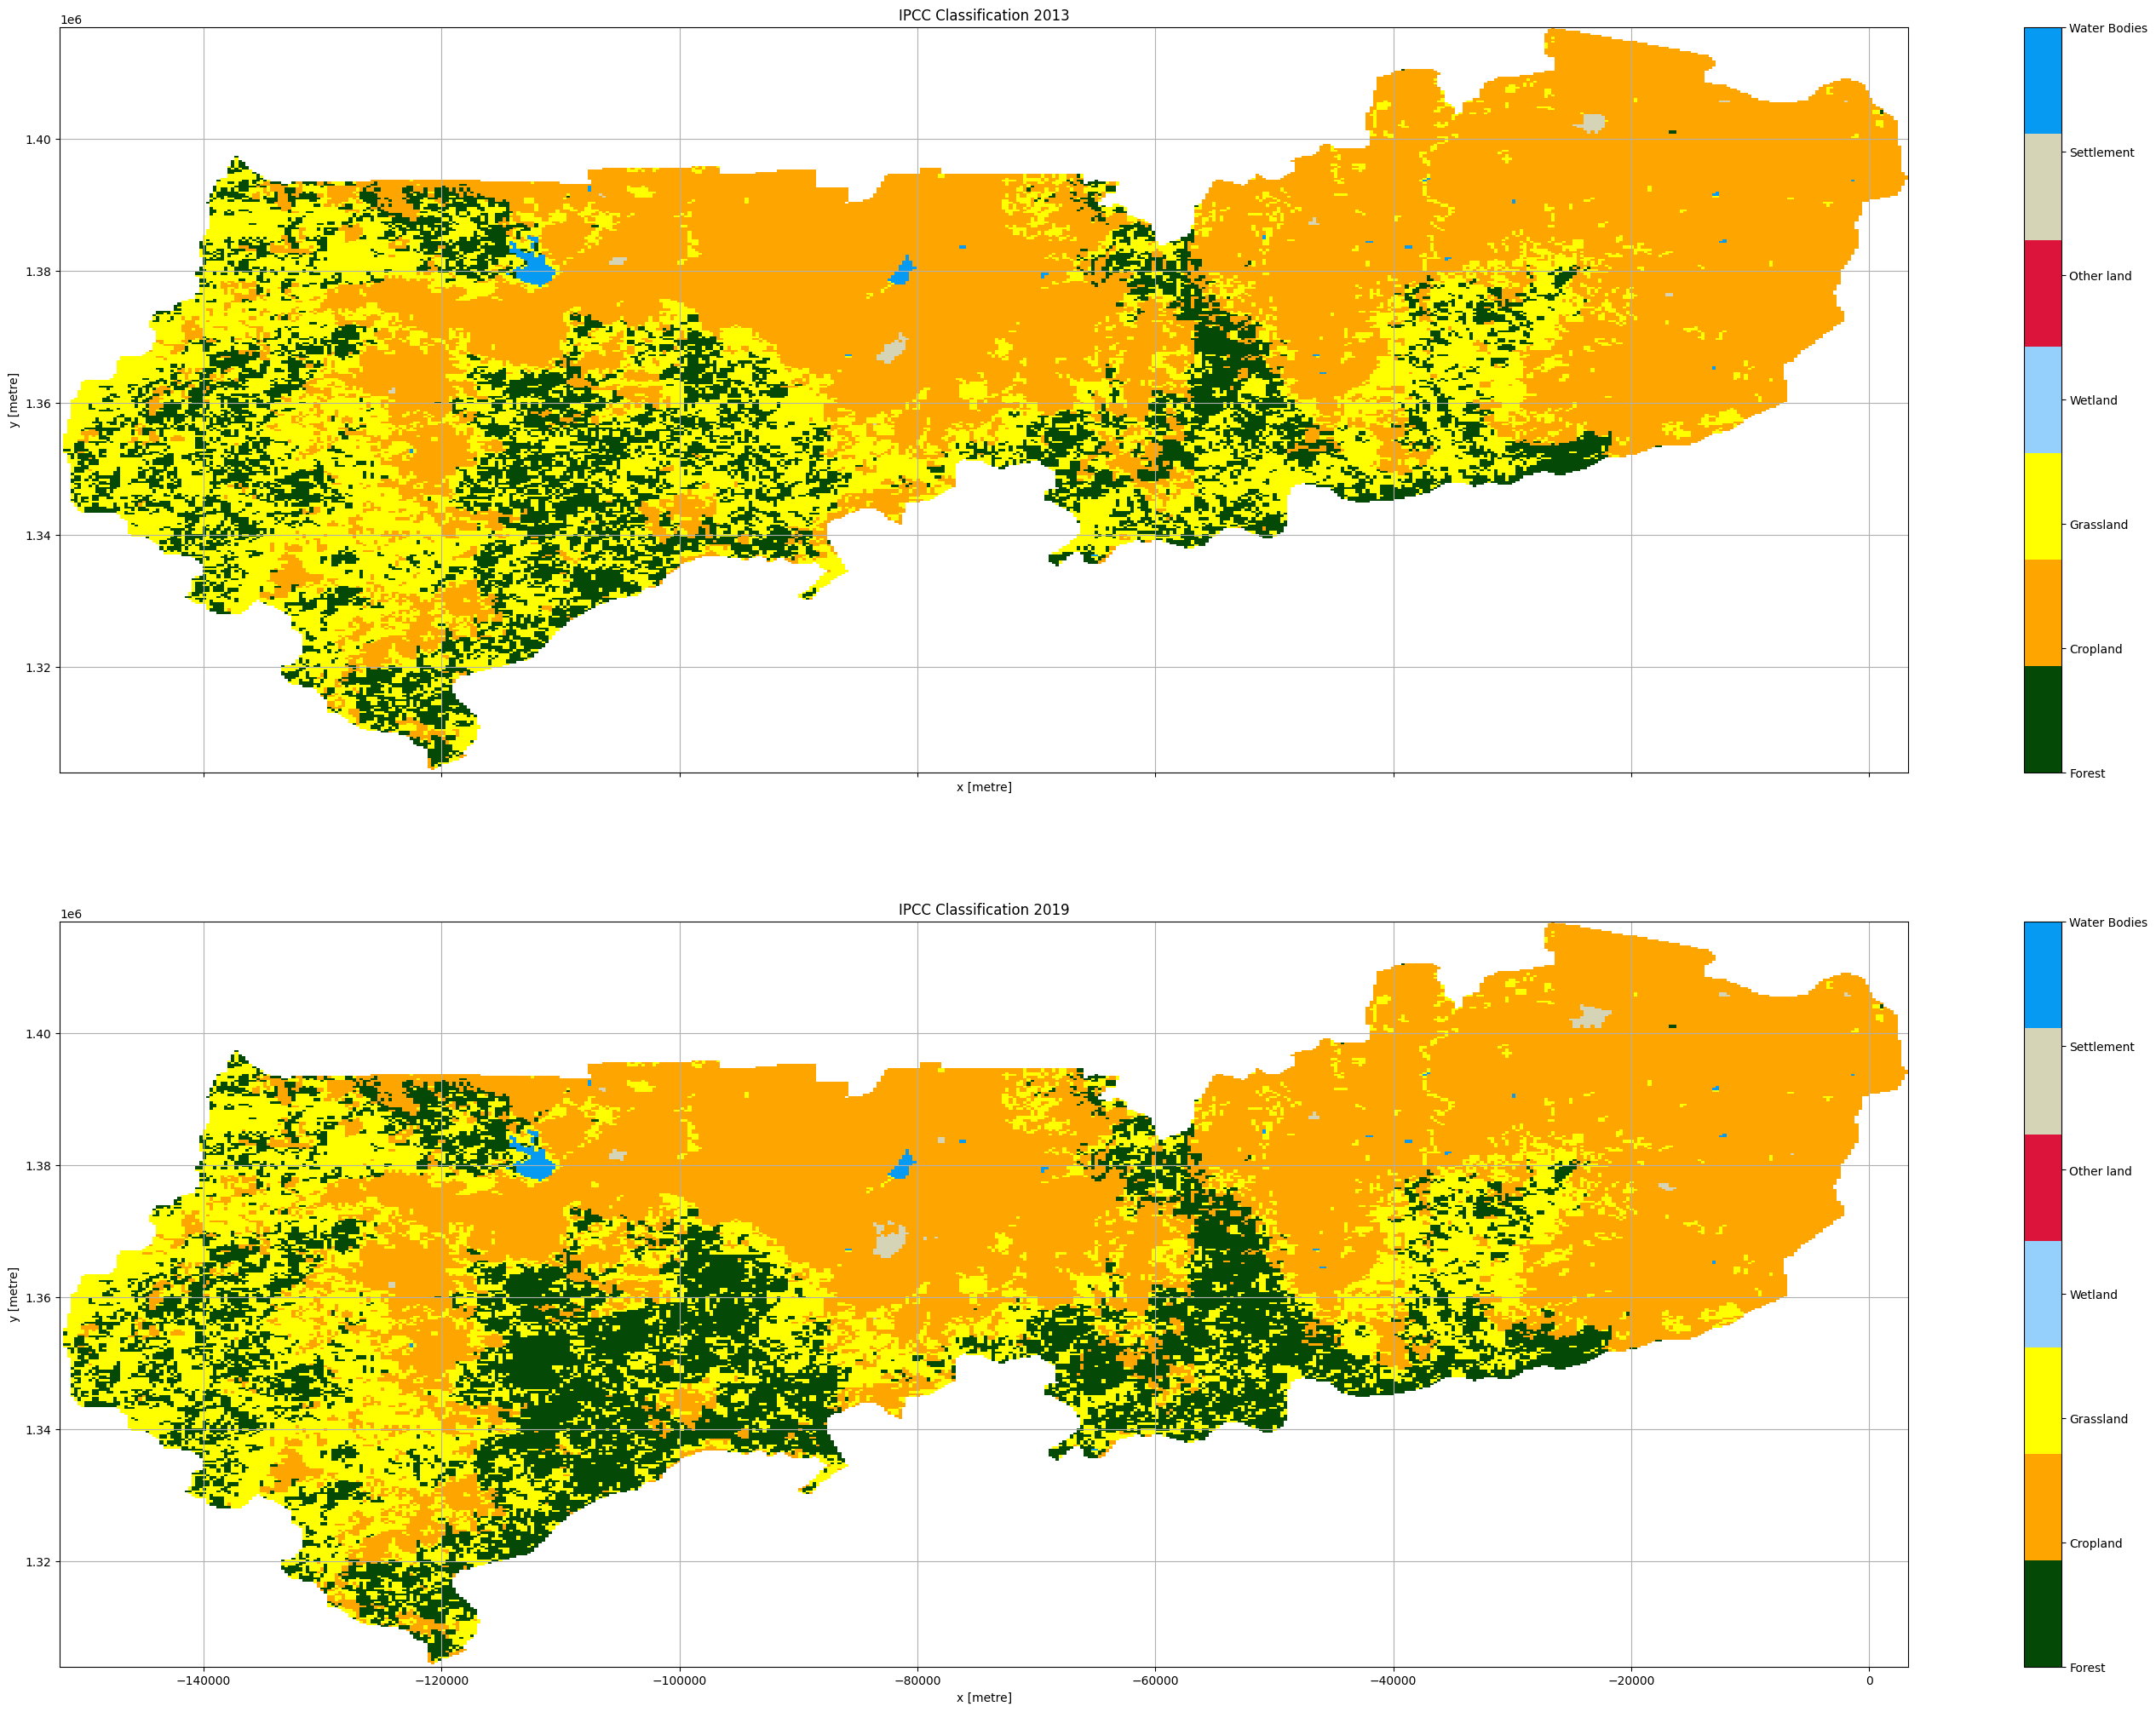

In [11]:
fig,ax = plt.subplots(2, 1, figsize=(35, 25), sharex=True)

clas = ds_2013.plot(add_colorbar=False, cmap=cmap, ax=ax[0])
clasp = plt.colorbar(clas)
clasp.set_ticks(ipcc_classess_num)
clasp.set_ticklabels(ipcc_classess)
ax[0].set_title(f"IPCC Classification {year_1}")
ax[0].grid()

clas = ds_2019.plot(add_colorbar=False, cmap=cmap, ax=ax[1])
clasp = plt.colorbar(clas)
clasp.set_ticks(ipcc_classess_num)
clasp.set_ticklabels(ipcc_classess)
ax[1].set_title(f"IPCC Classification {year_2}")
ax[1].grid()

plt.show()

### Calculate the area of each class

In [12]:
ds_2013_counts = np.unique(ds_2013.values, return_counts=True)
ds_2019_counts = np.unique(ds_2019.values, return_counts=True)

In [13]:
pixel_length = query["resolution"][1]
m_per_km = 1000
area_per_pixel = pixel_length**2 / m_per_km**2

#calculate the area of each class
ds_2013_counts_area = np.array(ds_2013_counts[1][:-1] * area_per_pixel)
ds_2019_counts_area = np.array(ds_2019_counts[1][:-1] * area_per_pixel)

#### Plotting of Area using Bar Graph

In [14]:
classess = ['Forest','Cropland','Grassland','Settlement','Water Bodies']

/tmp/ipykernel_629/120123922.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classess, rotation=90)
/tmp/ipykernel_629/120123922.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels( classess, rotation=90)


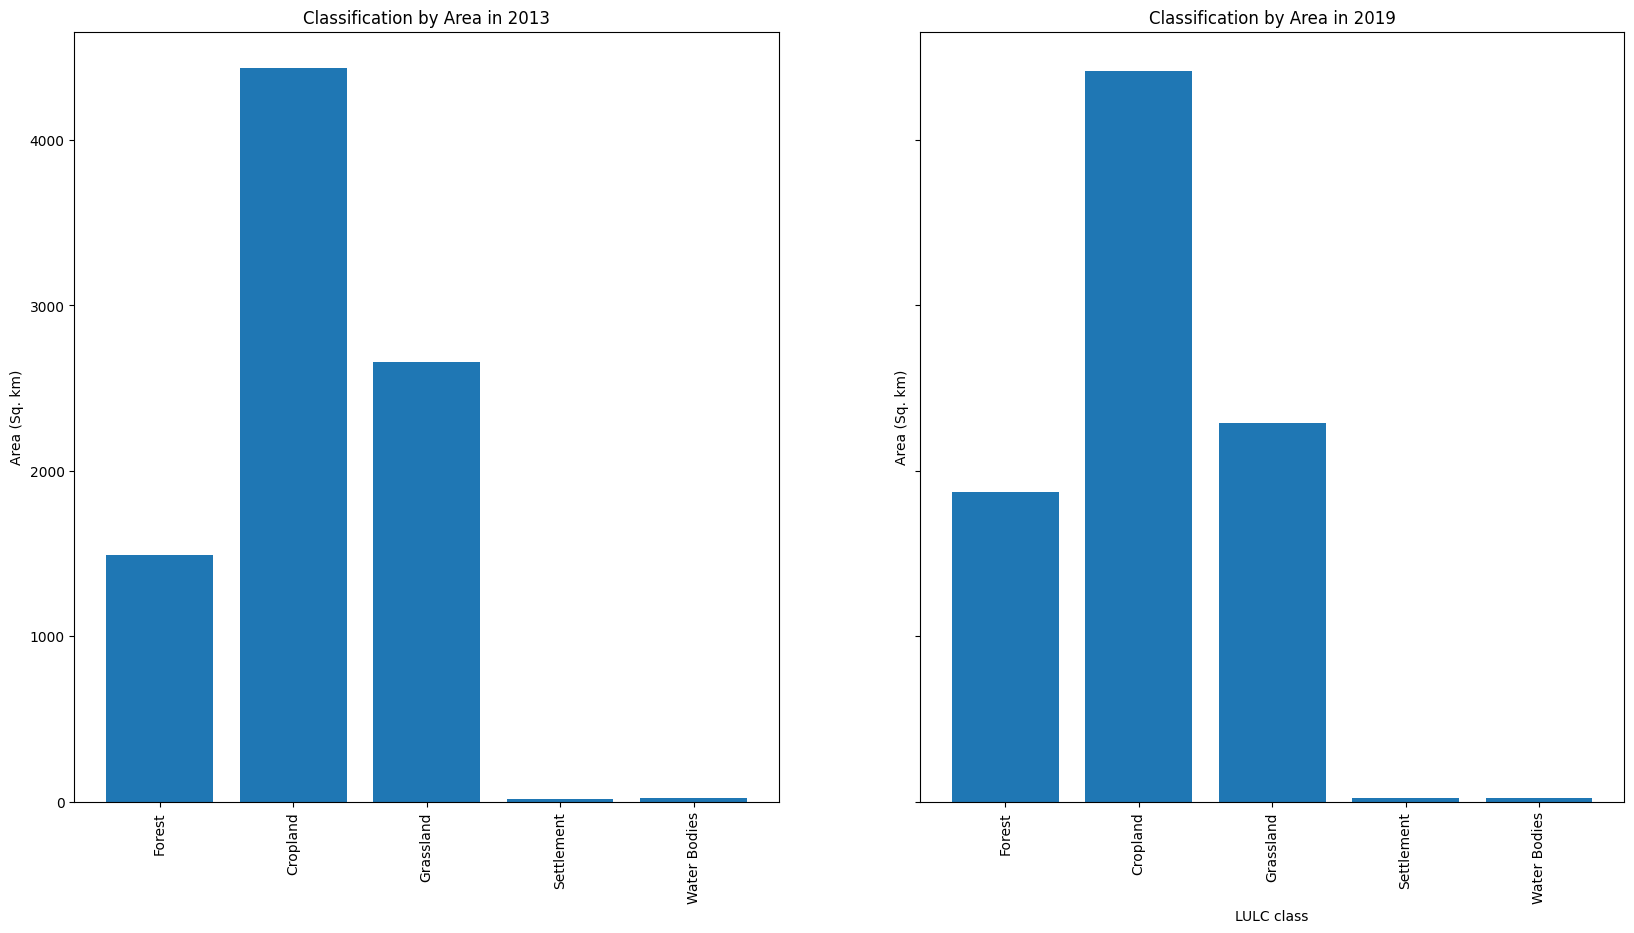

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10), sharey = True)

ax[0].bar(x = classess, height = ds_2013_counts_area)
ax[0].set_xticklabels(classess, rotation=90)
ax[0].set_ylabel("Area (Sq. km)")
ax[0].set_title(f"Classification by Area in {year_1}")

ax[1].bar(x = classess, height = ds_2019_counts_area)
ax[1].set_xticklabels( classess, rotation=90)
ax[1].set_ylabel("Area (Sq. km)")
ax[1].set_xlabel("LULC class")
ax[1].set_title(f"Classification by Area in {year_2}")

plt.show()

In [16]:
data = {
    year_1: ds_2013_counts_area,
    year_2: ds_2019_counts_area
}

df = pd.DataFrame(data, index=classess)

In [17]:
df['change'] = df['2019']-df['2013']

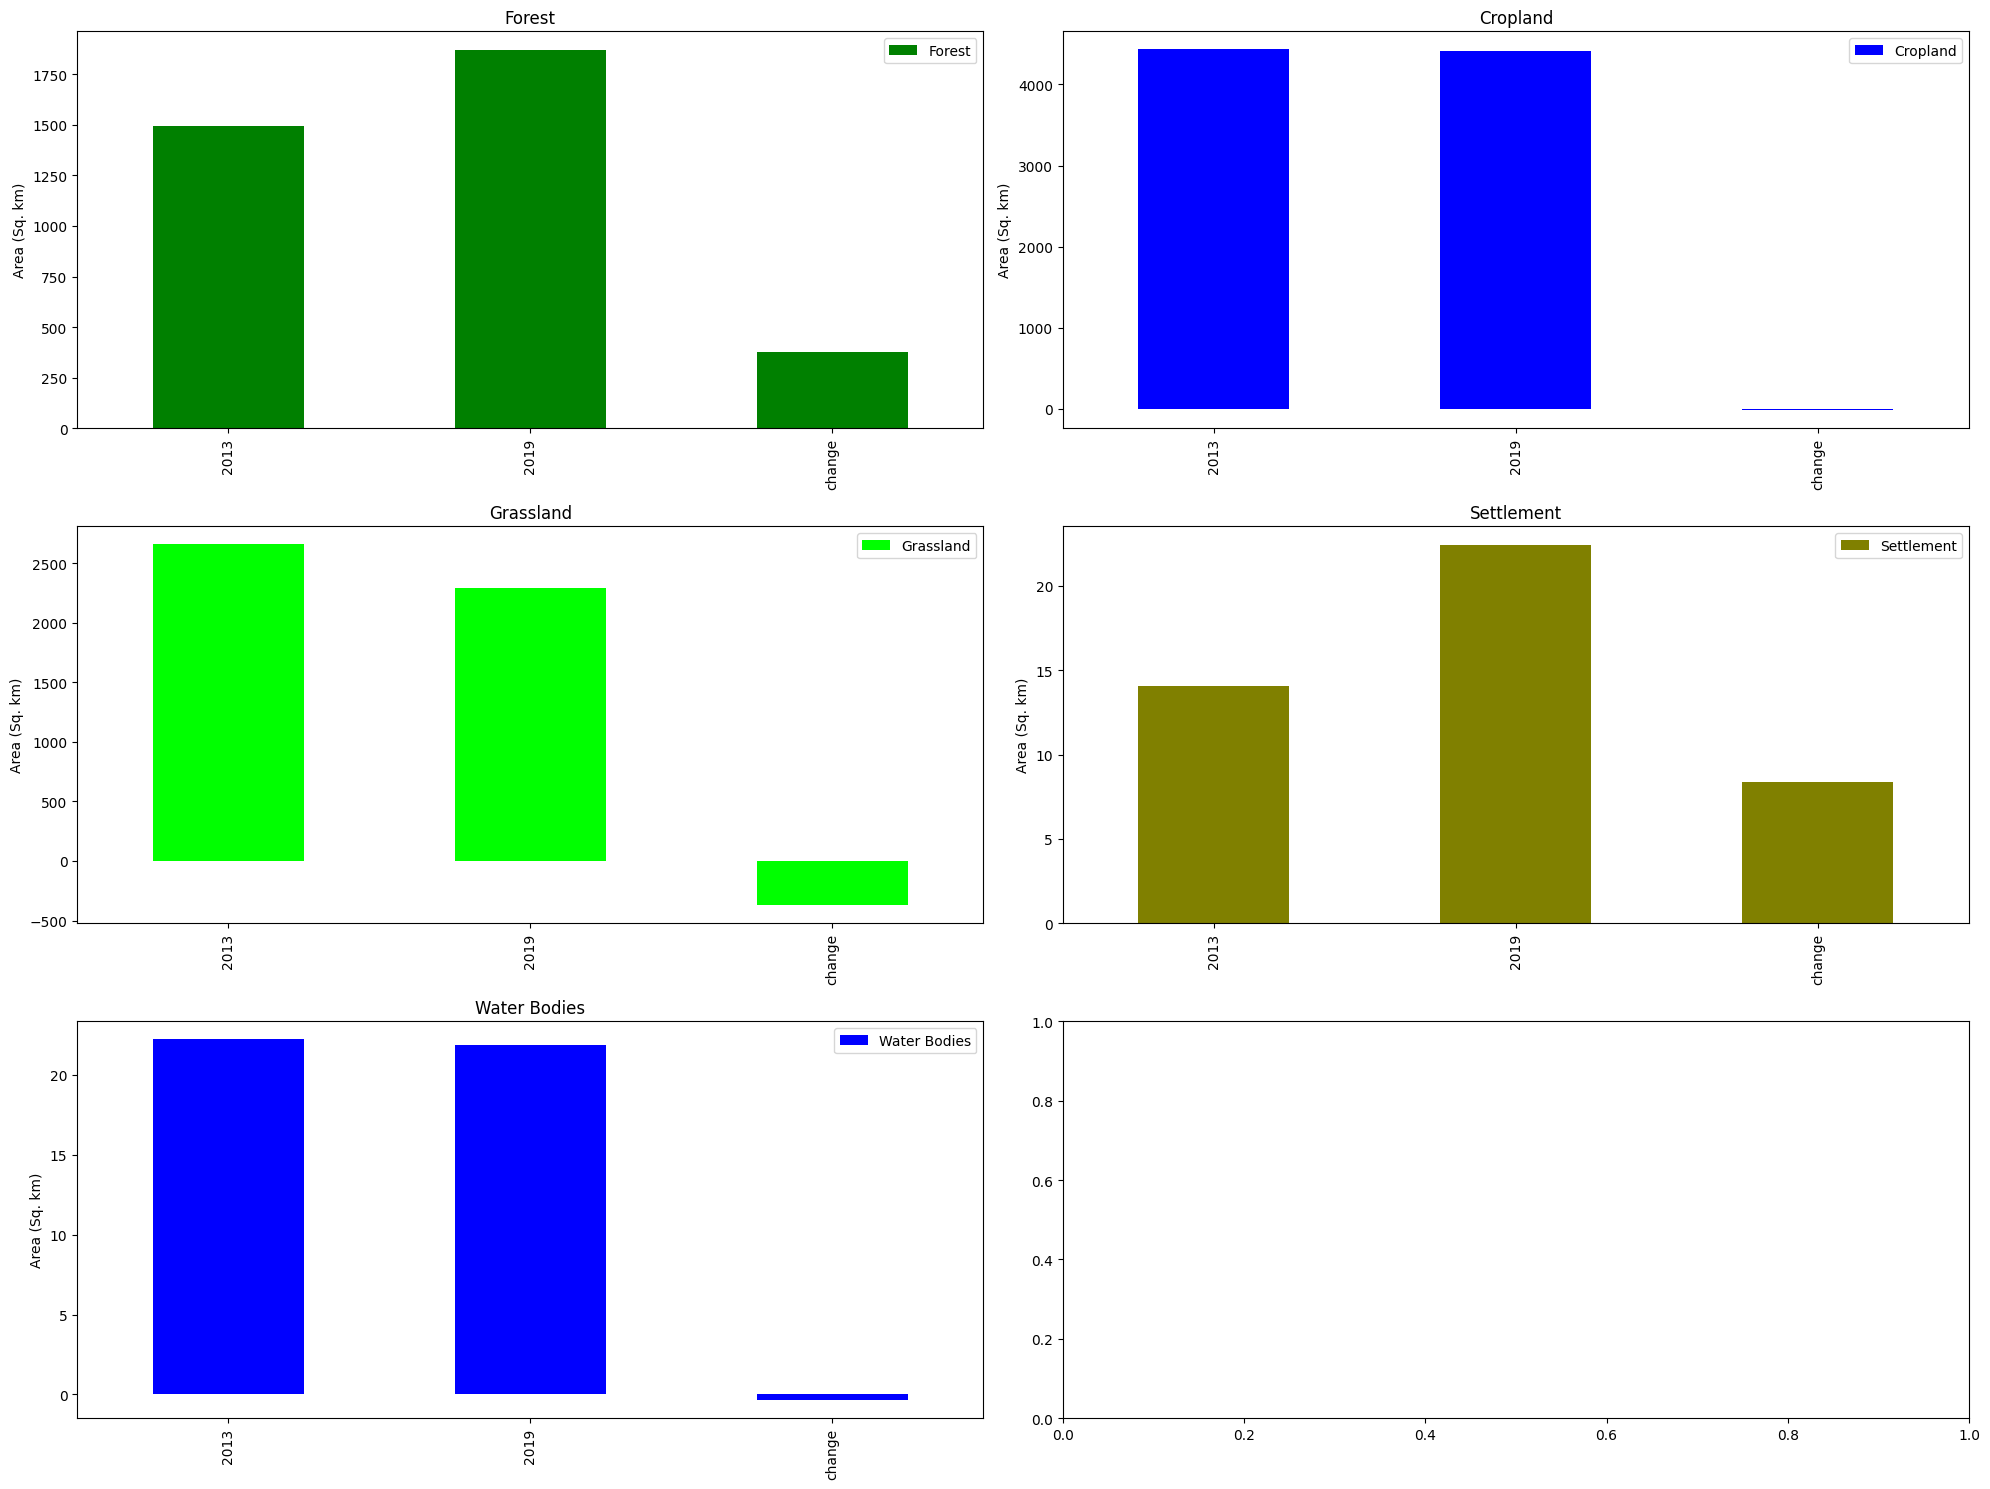

In [18]:
fig,ax = plt.subplots(3, 2, figsize=(20, 15))

df.iloc[0].plot(kind='bar', label=classess[0], color='Green', ax=ax[0, 0])
ax[0, 0].legend()
ax[0, 0].set_title(classess[0])
ax[0, 0].set_ylabel("Area (Sq. km)")

df.iloc[1].plot(kind='bar', label=classess[1], color='Blue', ax=ax[0, 1])
ax[0, 1].legend()
ax[0, 1].set_title(classess[1])
ax[0, 1].set_ylabel("Area (Sq. km)")

df.iloc[2].plot(kind='bar', label=classess[2], color='lime', ax=ax[1, 0])
ax[1, 0].legend()
ax[1, 0].set_title(classess[2])
ax[1, 0].set_ylabel("Area (Sq. km)")

df.iloc[3].plot(kind='bar', label=classess[3], color='olive', ax=ax[1, 1])
ax[1, 1].legend()
ax[1, 1].set_title(classess[3])
ax[1, 1].set_ylabel("Area (Sq. km)")

df.iloc[4].plot(kind='bar', label=classess[4], color='Blue', ax=ax[2, 0])
ax[2, 0].legend()
ax[2, 0].set_title(classess[4])
ax[2, 0].set_ylabel("Area (Sq. km)")

plt.tight_layout()